In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import time
import tqdm
import torch
import warnings
import numpy as np
import torch.nn as nn
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
import utilities as utils
import torch.nn.functional as F
from ipywidgets import interact
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [4]:
%matplotlib notebook
warnings.filterwarnings('ignore')

In [5]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [6]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

In [13]:
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    assert y1.shape == y2.shape
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    assert y1.shape == y2.shape
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    assert y1.shape == y2.shape
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Training Data

In [7]:
nsamples = 1200 # no. of samples
dim_x = 101
dim_y = dim_x
sim_steps = 600 # simulation steps
dx = 0.25 # delta space_dim
dt = 0.01 # delta time
gamma = 1.0 # interface energy
device = torch.device("cuda:0")

In [8]:
init_data1 = init_unif(nsamples//2, dim_x, dim_y, seed=354875)
init_data2 = init_norm(nsamples//2, dim_x, dim_y, seed=982632)
init_data = np.concatenate([init_data1, init_data2], axis=0)

In [9]:
%%time
x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, dx=dx, sim_step=100, device=device)

CPU times: user 4.98 s, sys: 3.95 s, total: 8.93 s
Wall time: 8.94 s


In [10]:
%%time
init_data1 = init_unif(250, dim_x, dim_y, seed=438645)
init_data2 = init_norm(250, dim_x, dim_y, seed=234580)
init_data = np.concatenate([init_data1, init_data2], axis=0)
x_val = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
y_val = ch.ch_run_torch(x_val, dt=dt, gamma=gamma, dx=dx, sim_step=100, device=device)

CPU times: user 5.12 s, sys: 1.36 s, total: 6.47 s
Wall time: 2.64 s


# CNN Model

In [11]:
from chnet.ch_net import CHnet
from chnet.ch_loader import CahnHillDataset

In [14]:
device = torch.device("cuda:0")

ks = 5 # kernel size
in_channels = 1 # no. of input channels
cw = 64 # channel width
model = CHnet(ks=ks, in_channels=in_channels, cw=cw).double().to(device)
lx = (ks // 2) * 5 
transformer_x = compose(lambda x: x[None], 
                        lambda x: np.pad(x, pad_width=[[lx,lx],[lx,lx]], mode='wrap'))

transformer_y = lambda x: x[None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)



item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.0186, device='cuda:0', dtype=torch.float64)


## Model Architecture

In [15]:
nprod = 0
for parameter in model.parameters():
    print(parameter.size())
    nprod += np.prod(parameter.size())
print("No. of Parameters: %d" % nprod)

torch.Size([64, 1, 5, 5])
torch.Size([64])
torch.Size([64, 64, 5, 5])
torch.Size([64])
torch.Size([128, 64, 5, 5])
torch.Size([128])
torch.Size([128, 128, 5, 5])
torch.Size([128])
torch.Size([256, 128, 5, 5])
torch.Size([256])
torch.Size([1024, 256, 1, 1])
torch.Size([1024])
torch.Size([2048, 1024, 1, 1])
torch.Size([2048])
torch.Size([1, 2048, 1, 1])
torch.Size([1])
No. of Parameters: 3902657


## Model Parameters

In [16]:
@curry
def add_neighbors(x):
    dimx = x.shape[0]
    y = np.pad(x, pad_width=[[2,2],[2,2]], mode="wrap")
    out = [x[None]]
    for ix in [0, 1, 2, 3, 4]:
        for iy in [0, 1, 2, 3, 4]:
            out.append((y[ix:ix+dimx, iy:iy+dimx] * x)[None])
    return np.concatenate(out, axis=0)

In [17]:
dimx = 5
x_data = pipe(dimx, 
              lambda x: np.arange(1, x**2+1), 
              lambda x: np.reshape(x, (dimx, dimx)))
x_data

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25]])

In [18]:
ks = 5 # kernel size
in_channels = 26 # no. of input channels
cw = 32 # channel width

train_batch_size = 2
val_batch_size = 2

transformer_x = compose(lambda x: add_neighbors(x), 
                        lambda x: np.pad(x, pad_width=[[lx,lx],[lx,lx]], mode='wrap'))

transformer_y = lambda x: x[None]

train_dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)
trainloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=1)

val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
valloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=1)

total_step = len(trainloader)
print("No. of training steps: %d" % total_step)
total_val_step = len(valloader)
print("No. of validation steps: %d" % total_val_step)

AssertionError: 

In [106]:
model = CHnet(ks=ks, in_channels=in_channels, cw=cw).double().to(device)

num_epochs = 10
criterion = mse_loss
learning_rate = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

In [107]:
# Loss and optimizer
for epoch in range(num_epochs):    
    if epoch % 5 == 0:
        torch.save(model.state_dict(), "weights/CH_trial_1_%d" % (epoch))
                   
    for i, item in enumerate(tqdm.tqdm_notebook(trainloader)):
        model.train()
        
        x = item['x'].to(device)
        target = item['y'].to(device)

        # Forward pass
        output = model(x)
        loss = criterion(output*100, target*100)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(np.sqrt(loss.item()))
        
        if (i) % 100 == 0:
            for indx in np.random.permutation(np.arange(0, len(val_dataset)))[:5]:
                model.eval()
                item1 = val_dataset[indx]
                x1 = item1['x'][None].to(device)
                y1 = item1['y'][None].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(train_losses[-50:]), 
                                                                                                          np.mean(val_losses[-5:])))

Epoch [1/10], Step [1/6000], Training Loss: 70.06677529694, Validation Loss: 0.69686554700
Epoch [1/10], Step [101/6000], Training Loss: 3.66771990121, Validation Loss: 0.02343377226
Epoch [1/10], Step [201/6000], Training Loss: 1.66140360963, Validation Loss: 0.01497026031
Epoch [1/10], Step [301/6000], Training Loss: 1.41279797066, Validation Loss: 0.01458935683
Epoch [1/10], Step [401/6000], Training Loss: 1.33298575024, Validation Loss: 0.01341868501
Epoch [1/10], Step [501/6000], Training Loss: 1.16892771979, Validation Loss: 0.01161260780
Epoch [1/10], Step [601/6000], Training Loss: 1.14403748125, Validation Loss: 0.00976567113
Epoch [1/10], Step [701/6000], Training Loss: 1.00444926569, Validation Loss: 0.00934214889
Epoch [1/10], Step [801/6000], Training Loss: 0.98376865646, Validation Loss: 0.00828841621
Epoch [1/10], Step [901/6000], Training Loss: 0.99823025615, Validation Loss: 0.00809939071
Epoch [1/10], Step [1001/6000], Training Loss: 0.90448833984, Validation Loss: 0.

Epoch [2/10], Step [1/6000], Training Loss: 0.76532644584, Validation Loss: 0.00668746859
Epoch [2/10], Step [101/6000], Training Loss: 0.74972570589, Validation Loss: 0.00541933541
Epoch [2/10], Step [201/6000], Training Loss: 0.71305188867, Validation Loss: 0.00869406129
Epoch [2/10], Step [301/6000], Training Loss: 0.71628118573, Validation Loss: 0.00533165244
Epoch [2/10], Step [401/6000], Training Loss: 0.76846159878, Validation Loss: 0.00681125624
Epoch [2/10], Step [501/6000], Training Loss: 0.78146670808, Validation Loss: 0.00572035634
Epoch [2/10], Step [601/6000], Training Loss: 0.78186431746, Validation Loss: 0.00702684167
Epoch [2/10], Step [701/6000], Training Loss: 0.66585015967, Validation Loss: 0.00655805739
Epoch [2/10], Step [801/6000], Training Loss: 0.70735757852, Validation Loss: 0.00782770961
Epoch [2/10], Step [901/6000], Training Loss: 0.76875924931, Validation Loss: 0.00742586516
Epoch [2/10], Step [1001/6000], Training Loss: 0.70227791581, Validation Loss: 0.0

Epoch [3/10], Step [1/6000], Training Loss: 0.74328778199, Validation Loss: 0.00798760121
Epoch [3/10], Step [101/6000], Training Loss: 0.75177953698, Validation Loss: 0.00611706153
Epoch [3/10], Step [201/6000], Training Loss: 0.82020804592, Validation Loss: 0.00771358569
Epoch [3/10], Step [301/6000], Training Loss: 0.81511529648, Validation Loss: 0.00677553408
Epoch [3/10], Step [401/6000], Training Loss: 0.70889798358, Validation Loss: 0.00498823257
Epoch [3/10], Step [501/6000], Training Loss: 0.64571845118, Validation Loss: 0.00557134664
Epoch [3/10], Step [601/6000], Training Loss: 0.69449005866, Validation Loss: 0.00563848953
Epoch [3/10], Step [701/6000], Training Loss: 0.65511288122, Validation Loss: 0.00639876837
Epoch [3/10], Step [801/6000], Training Loss: 0.80612741183, Validation Loss: 0.00650587150
Epoch [3/10], Step [901/6000], Training Loss: 0.85408783144, Validation Loss: 0.00561803488
Epoch [3/10], Step [1001/6000], Training Loss: 0.78025693855, Validation Loss: 0.0

Epoch [4/10], Step [1/6000], Training Loss: 0.63874404490, Validation Loss: 0.00576464790
Epoch [4/10], Step [101/6000], Training Loss: 0.67960879427, Validation Loss: 0.00518123640
Epoch [4/10], Step [201/6000], Training Loss: 0.70435763558, Validation Loss: 0.00565409152
Epoch [4/10], Step [301/6000], Training Loss: 0.78576168177, Validation Loss: 0.00770438882
Epoch [4/10], Step [401/6000], Training Loss: 0.65550460183, Validation Loss: 0.00529340921
Epoch [4/10], Step [501/6000], Training Loss: 0.70334859632, Validation Loss: 0.00502250595
Epoch [4/10], Step [601/6000], Training Loss: 0.65629440351, Validation Loss: 0.00494305396
Epoch [4/10], Step [701/6000], Training Loss: 0.74474918520, Validation Loss: 0.00625428753
Epoch [4/10], Step [801/6000], Training Loss: 0.68586147509, Validation Loss: 0.00545310877
Epoch [4/10], Step [901/6000], Training Loss: 0.81497656663, Validation Loss: 0.00833537672
Epoch [4/10], Step [1001/6000], Training Loss: 0.71715249082, Validation Loss: 0.0

Process Process-15:
Traceback (most recent call last):
  File "/nv/hp22/ashanker9/data/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/nv/hp22/ashanker9/data/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/nv/hp22/ashanker9/data/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/nv/hp22/ashanker9/data/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 184, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/nv/hp22/ashanker9/data/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 184, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


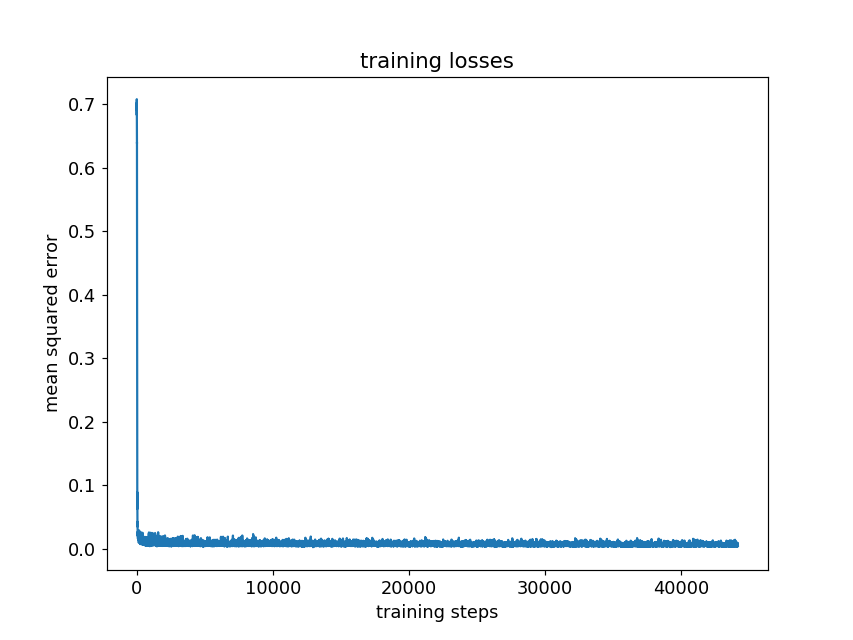

In [84]:
plt.plot(train_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.show()

<IPython.core.display.Javascript object>


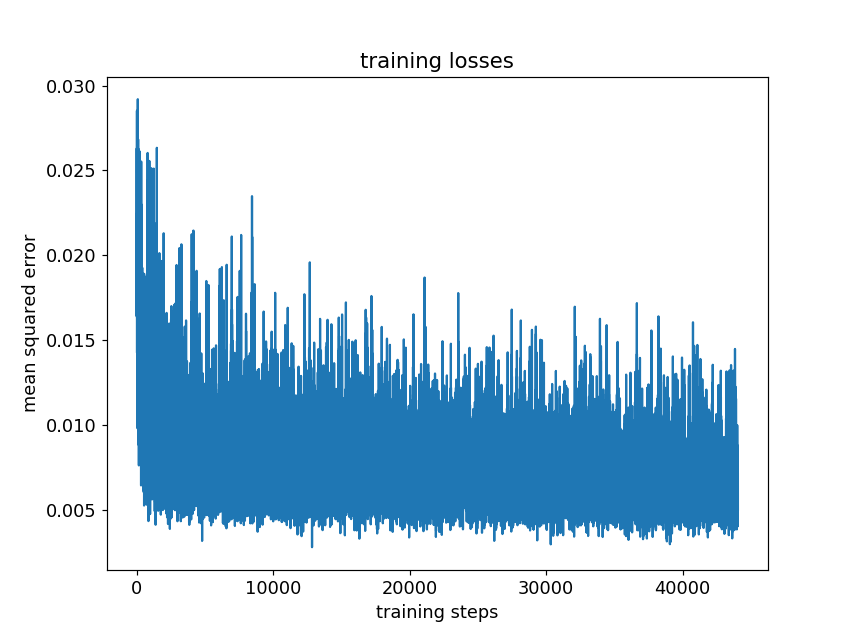

In [94]:
plt.plot(train_losses[100:])
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.show()

<IPython.core.display.Javascript object>


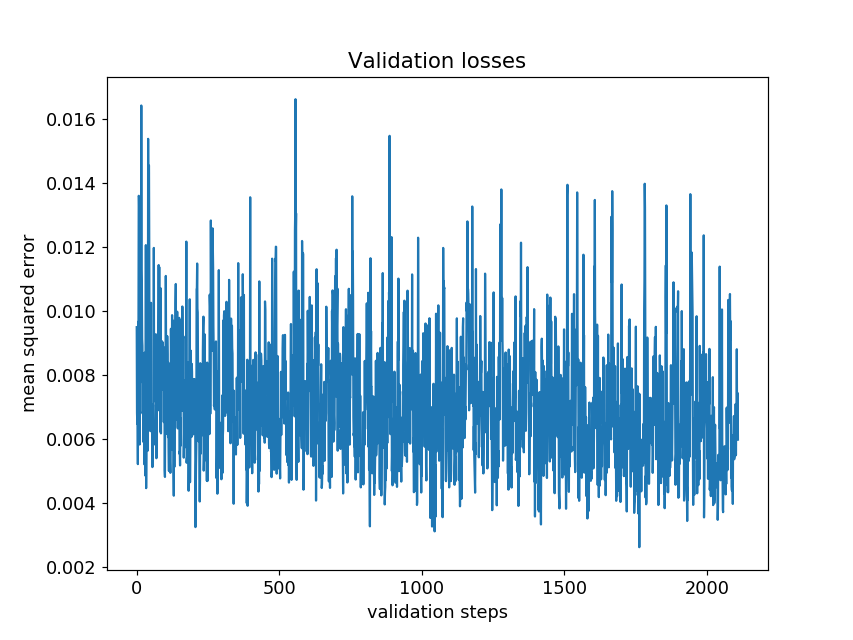

In [91]:
plt.plot(val_losses[100:])
plt.title("Validation losses")
plt.xlabel("validation steps")
plt.ylabel("mean squared error")
plt.show()

In [86]:
model.eval()
item1 = val_dataset[indx]
x1 = item1['x'][None].to(device)
y1 = item1['y'][None].to(device)
# Forward pass
y2 = model(x1)

<IPython.core.display.Javascript object>


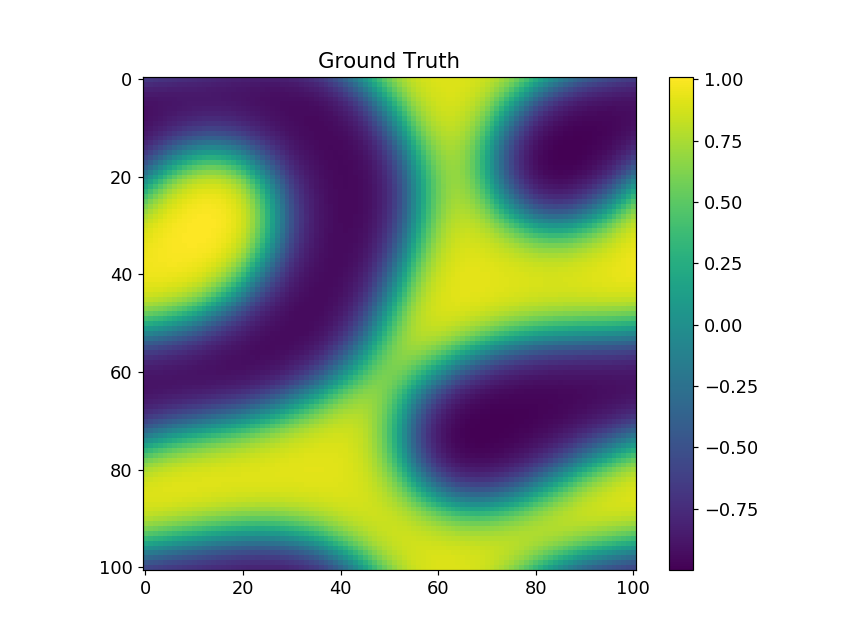

In [87]:
draw_im(y1.detach().cpu().numpy(), "Ground Truth")

<IPython.core.display.Javascript object>


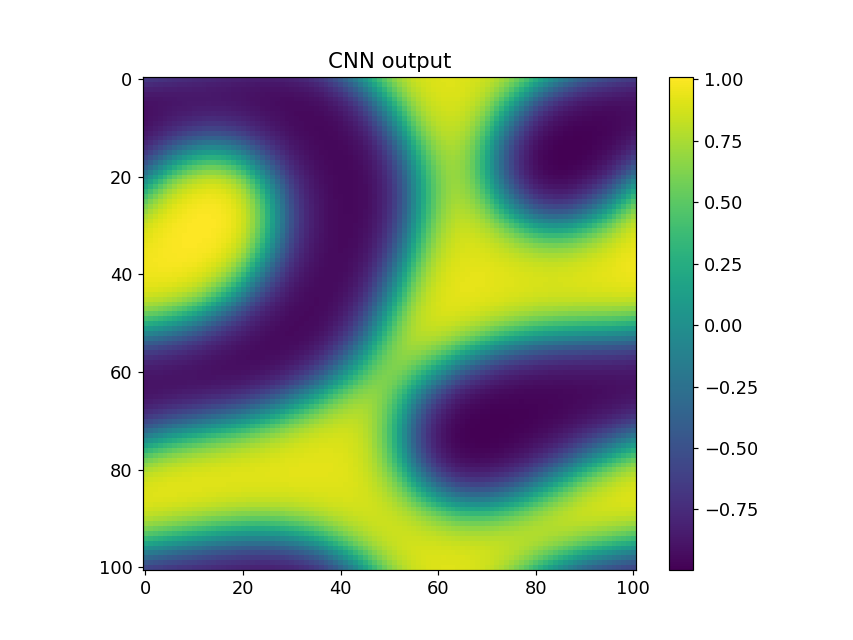

In [88]:
draw_im(y2.detach().cpu().numpy(), "CNN output")

<IPython.core.display.Javascript object>


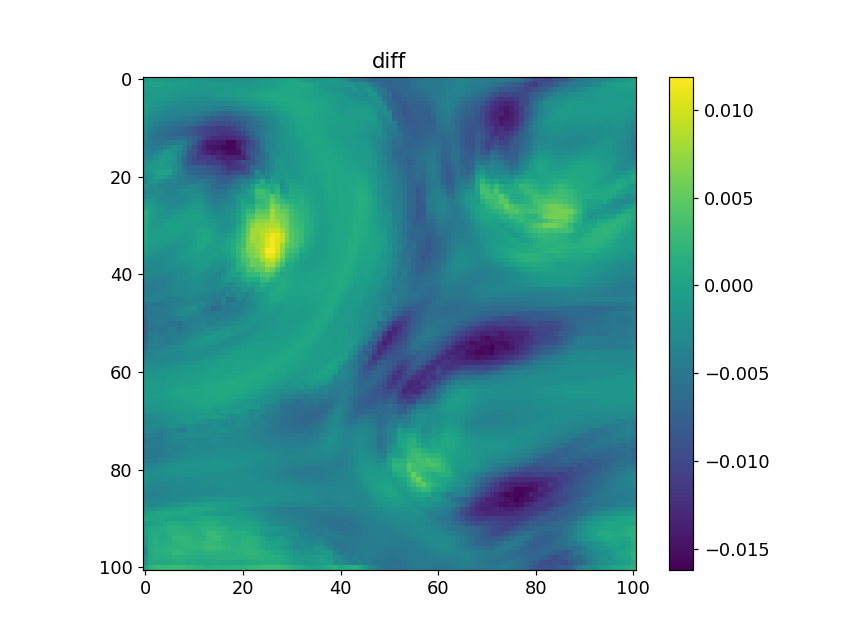

In [89]:
draw_im(y1.detach().cpu().numpy() - y2.detach().cpu().numpy(), "diff")